### Preparation of Georeferenced DHS Indicator Data

In [1]:
import os
import functions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterstats
import sys
from shapely.geometry import Point
import rasterio
import rioxarray
from rasterio.enums import Resampling
from osgeo import gdal

In [3]:
from importaciones_mapas import *
import mapas
import mapas_raster

path_one_drive = '/CloudStorage/OneDrive-Bibliotecascompartidas:VestigiumMétodosMixtosAplicadosSAS/'
paths = mapas.diccionario_rutas(path_OneDrive=path_one_drive)


## Parameters

In [2]:
data_folder = '/CloudStorage/OneDrive-Bibliotecascompartidas:VestigiumMétodosMixtosAplicadosSAS/MMC - General - SIG/DISES/data/'

## Preparation of Geospatial Covariate Layers

### Get the base grid and data from the raster

In [149]:
#Read the initial rasterfile
initial_raster_path = os.path.join(data_folder, 'KHM/data_preprocessed_image_5000m-20240724_aoi_geom_egd_5km.tif')
# Open the raster file as a shape
country_grids = functions.raster_to_gdf(initial_raster_path)

# Add an ID to identify the grids
country_grids['grid_id'] = range(1, len(country_grids)+1)
country_grids['grid_id'] = 'id' + country_grids['grid_id'].astype(str)

In [7]:
#Select only needed variables
df = country_grids[['grid_id','geometry']].reset_index(drop=True)

In [8]:
#country_grids.to_file(data_folder + 'KHM/grids/country_grids.shp')

In [9]:
# Import country shapefile
country_bounds = gpd.read_file(data_folder + 'data/KHM/country_boundary/country_bounds.shp')


Text(29.47222222222222, 0.5, 'Latitude')

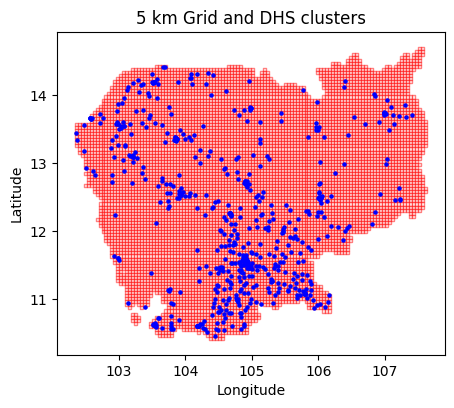

In [10]:
# Open the raster file
gdf = functions.raster_to_gdf(initial_raster_path)

# Create a plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the GeoDataFrame
gdf.plot(ax=ax, facecolor='white', edgecolor='red', alpha=0.5)

# Plot the points on top
path =  os.path.join(data_folder, 'KHM/mpi_khm_dhs14_cot_clust_CI_mis/mpi_khm_dhs14_cot_clust_CI_mis.shp')
dhs = gpd.read_file(path)
dhs = functions.exclude_zero_coordinates(dhs)

dhs.plot(ax=ax, color='blue', markersize=5)

# Customize the plot (optional)
ax.set_title('5 km Grid and DHS clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

### Adding new covariates

- We use as a reference the list of covariates from SAR 11 but add from other sources.

- These are the original layers used in SAR 11: 

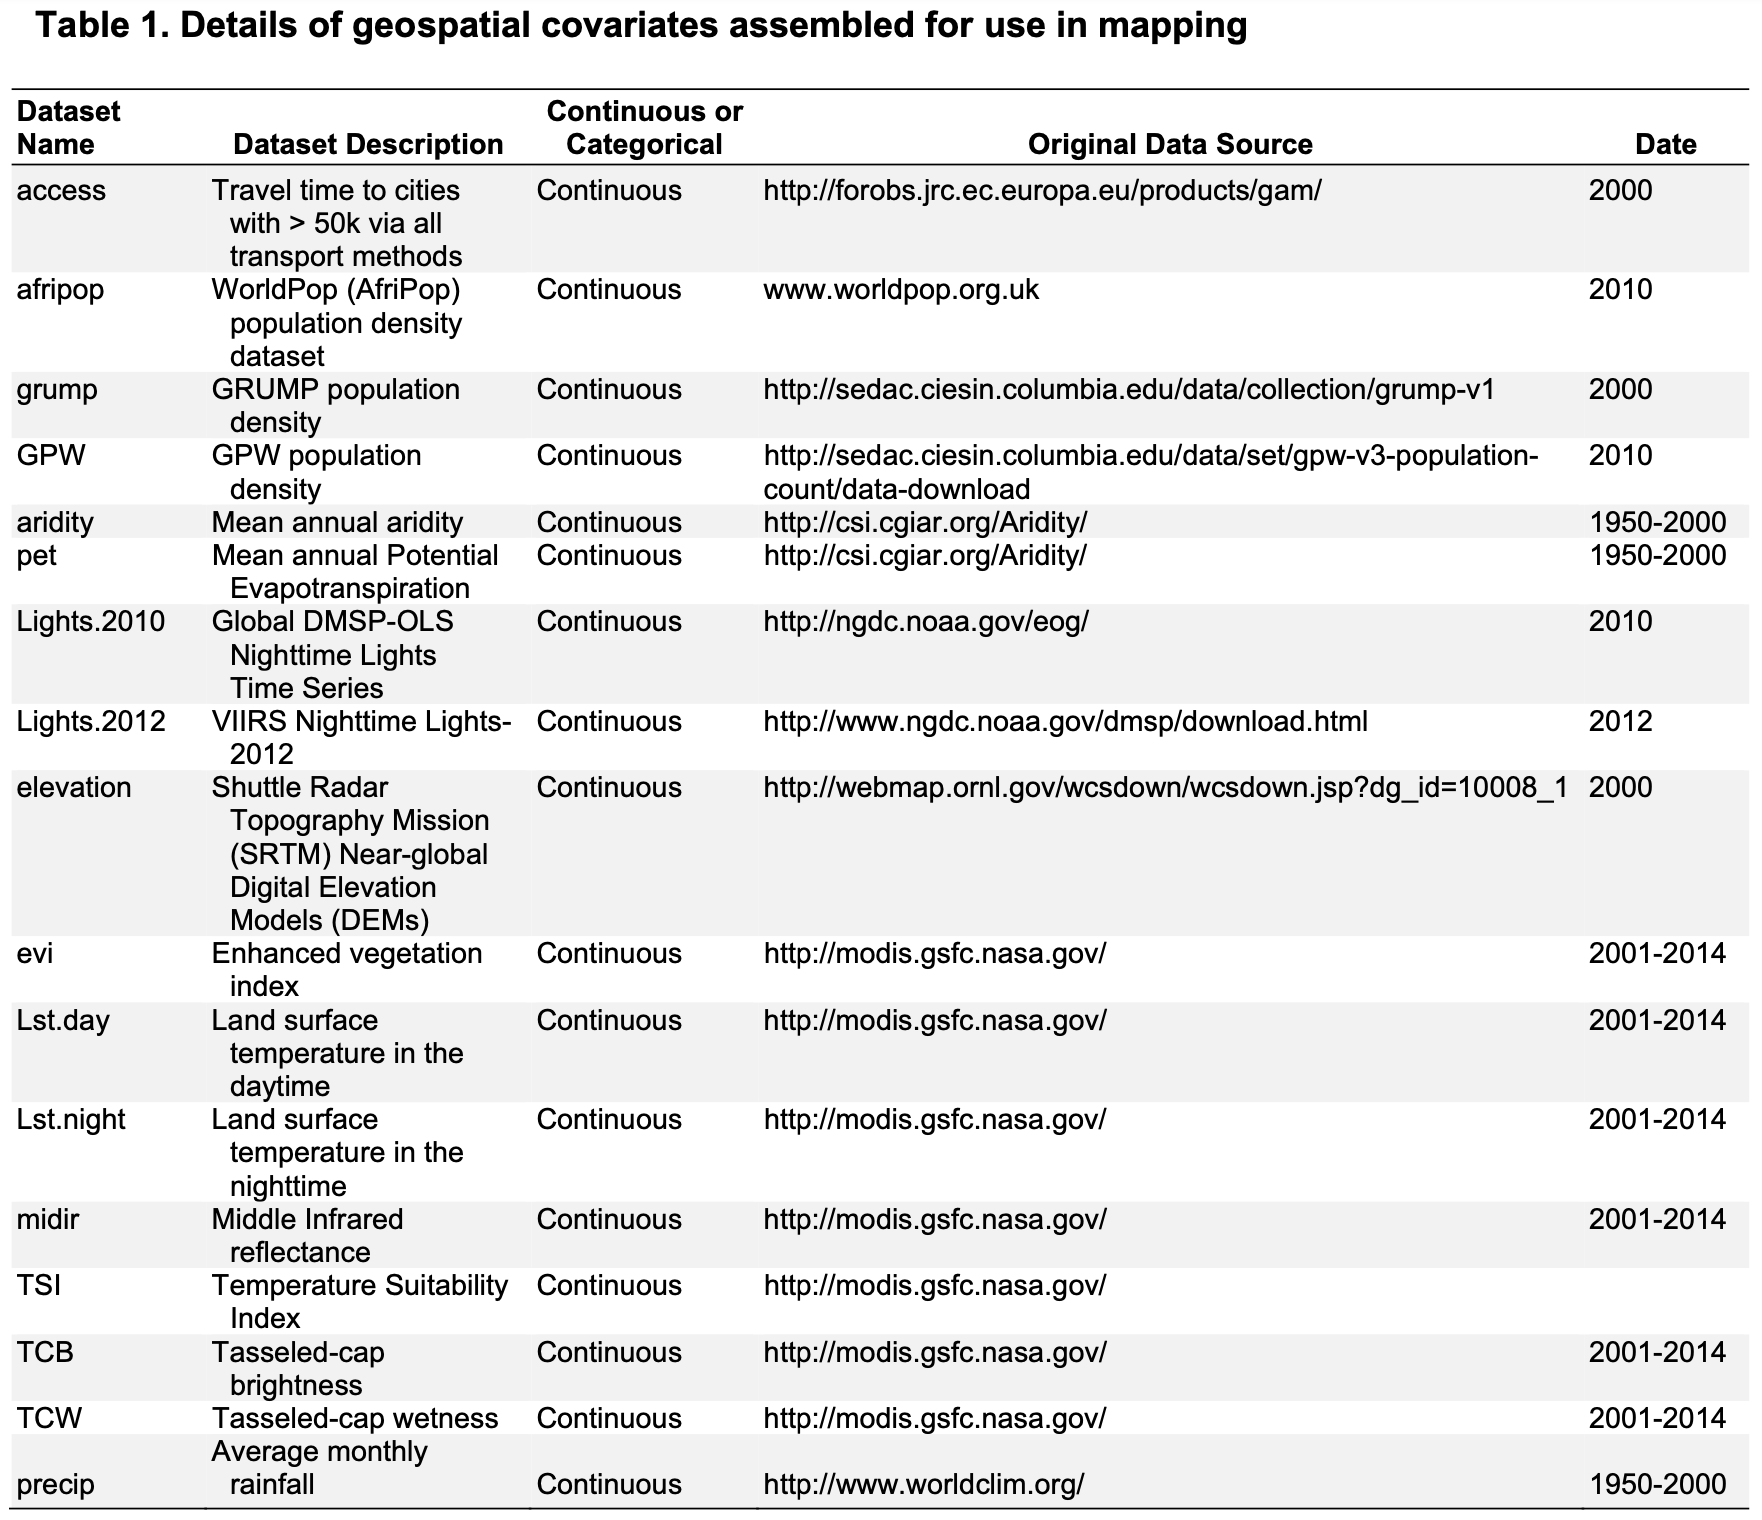

- The list of covariates to add and their sources: 

#### GDP

##### Second approach
This approach converts the .nc file into a .tif file for better handling. After that, it calculates the zonal stats for the shapefile of the country grids. Both the 5arcmin (10km) and 30arcsec (1km) can be used.

In [11]:
#import data
nc_file = xr.open_dataset(data_folder + 'gdp/doi_10_5061_dryad_dk1j0__v20200213/GDP_PPP_30arcsec_v3.nc')


In [12]:
%%time
#There's no need to run this again 

# Convert a .nc file to a .tif file
for year in [2015, 2000, 1990]:
    
    #import data
    nc_file = xr.open_dataset(data_folder + 'gdp/doi_10_5061_dryad_dk1j0__v20200213/GDP_PPP_30arcsec_v3.nc')
    
    #Select the band
    gdp_ppp = nc_file['GDP_PPP']
    
    #Select the year
    time_index = (gdp_ppp['time'] == year).argmax().values
    gdp_ppp_year = gdp_ppp.isel(time=time_index)
    
    #Provide spatial axis
    gdp_ppp_year.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
    gdp_ppp_year.rio.crs
    
    #Set projection system
    gdp_ppp_year.rio.write_crs("epsg:4326", inplace=True)
    
    #Export .tif file
    save_path = os.path.join(data_folder, f'gdp/gdp_ppp_{year}_30arcsec.tif')
    #gdp_ppp_year.rio.to_raster(save_path)

CPU times: user 29.2 ms, sys: 10.5 ms, total: 39.8 ms
Wall time: 41 ms


In [16]:
functions.raster_freq_table(os.path.join(data_folder, "gdp/gpd_ppp_1990_30arcsec_khm_mod.tif"))

,Value,Frequency
0,0.00,277028
1,3.70,2
2,5.73,1
3,8.85,1
4,8.86,1
...,...,...
52337,"233,294,576.00",1
52338,"252,025,936.00",1
52339,"259,379,280.00",1
52340,"268,524,672.00",1


In [13]:
%%time

#There's no need to run this again 

'''This code replace values containing -9 (no data) for 0'''

for year in [1990, 2000, 2015]:

    # Path to the original raster
    gdp_original_path = os.path.join(data_folder, f'gdp/gpd_ppp_{year}_30arcsec_khm.tif') 
    
    #Open raster
    original_raster = gdal.Open(gdp_original_path)
    
    # Read the raster band as a numpy array
    band = original_raster.GetRasterBand(1)
    array = band.ReadAsArray()
    
    # Count number of zero values before replacement
    num_zeros_before = np.count_nonzero(array == 0)
    
    # Replace pixel values of 252, 253, and 254 with no data value
    no_data_value = 0
    replacement_values = [-9]
    for value in replacement_values:
        array[array == value] = no_data_value
    
    # Create a new output path for the modified raster
    gdp_output_path = os.path.join(data_folder, f'gdp/gpd_ppp_{year}_30arcsec_khm_mod.tif')
    
    # Create a new raster file to write the modified array
    driver = gdal.GetDriverByName("GTiff")
    modified_raster = driver.Create(gdp_output_path, original_raster.RasterXSize, original_raster.RasterYSize, 1, gdal.GDT_Float32)
    modified_raster.GetRasterBand(1).WriteArray(array)
    
    # Set the projection and geotransform
    modified_raster.SetProjection(original_raster.GetProjection())
    modified_raster.SetGeoTransform(original_raster.GetGeoTransform())
    
    # Close the raster datasets
    original_raster = None
    modified_raster = None
    
    print("Processing complete.")

Processing complete.
Processing complete.
Processing complete.
CPU times: user 21.3 ms, sys: 19.6 ms, total: 40.9 ms
Wall time: 85 ms


In [11]:
def calculate_gdp_ppp(gdf, gdf_path, raster_path, column_name):
    stat='sum'
    col_name = column_name
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)
    return gdf

In [12]:
%%time
#Calcular las estadísticas de población
for year in [2015, 2000, 1990]:
    
    df = calculate_gdp_ppp(gdf=df,
                           gdf_path=data_folder + 'KHM/grids/country_grids.shp',
                           raster_path=os.path.join(data_folder+ f"gdp/gpd_ppp_{str(year)}_30arcsec_khm_mod.tif"), 
                           column_name=f'gdp30_{str(year)}')


CPU times: user 2min 55s, sys: 4.31 s, total: 2min 59s
Wall time: 3min 1s


#### Population density

In [13]:
def population_density(gdf, gdf_path, raster_path):
    stat='mean'
    col_name = 'pobdens20'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)
    return gdf
    

In [14]:
%%time
#Clipped raster path
pop_density_khm = os.path.join(data_folder, 'population/gpw_v4_population_density_khm.tif')

CPU times: user 22 μs, sys: 15 μs, total: 37 μs
Wall time: 123 μs


In [15]:
%%time
#Calcular las estadísticas de población
df = population_density(gdf=df,
                        gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'),
                        raster_path=pop_density_khm)

CPU times: user 59.6 s, sys: 1.55 s, total: 1min 1s
Wall time: 1min 2s


#### Population count

In [16]:
def population_count(gdf, gdf_path, raster_path):
    stat='sum'
    col_name = 'pobcount20'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)
    return gdf
    

In [17]:
%%time
#Clipped raster path
pop_count_khm = data_folder + 'population/gpw_v4_population_count_khm.tif'

CPU times: user 2 μs, sys: 4 μs, total: 6 μs
Wall time: 6.91 μs


In [18]:
%%time
#Calcular las estadísticas de población
df = population_count(gdf=df,
                        gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'),
                        raster_path=pop_count_khm)

CPU times: user 58.2 s, sys: 1.34 s, total: 59.5 s
Wall time: 59.8 s


#### Travel time

In [27]:
functions.raster_freq_table(data_folder+'acess_to_market/travel_time_to_cities_khm_mod.tif')

,Value,Frequency
0,0.00,4726
1,1.00,708
2,2.00,1615
3,3.00,1888
4,4.00,1532
...,...,...
1534,"1,610.00",1
1535,"1,623.00",1
1536,"1,633.00",1
1537,"1,634.00",1


In [24]:
%%time
#There's no need to run this again
'''This code replace values containing 65535 (no data) for nan'''

# Path to the original raster
acess_original_path = os.path.join(data_folder, 'acess_to_market/travel_time_to_cities_khm.tif') 

#Open raster
original_raster = gdal.Open(acess_original_path)

# Read the raster band as a numpy array
band = original_raster.GetRasterBand(1)
array = band.ReadAsArray()

# Count number of zero values before replacement
num_zeros_before = np.count_nonzero(array == 0)

# Convert the integer array to a float array
array = array.astype(float)

# Replace 65535 with np.nan
array[array == 65535] = np.nan

# Create a new output path for the modified raster
acess_output_path = os.path.join(data_folder, 'acess_to_market/travel_time_to_cities_khm_mod.tif')

# Create a new raster file to write the modified array
driver = gdal.GetDriverByName("GTiff")
modified_raster = driver.Create(acess_output_path, original_raster.RasterXSize, original_raster.RasterYSize, 1, gdal.GDT_Float32)
modified_raster.GetRasterBand(1).WriteArray(array)

# Set the projection and geotransform
modified_raster.SetProjection(original_raster.GetProjection())
modified_raster.SetGeoTransform(original_raster.GetGeoTransform())

# Close the raster datasets
original_raster = None
modified_raster = None

print("Processing complete.")

Processing complete.
CPU times: user 2.66 ms, sys: 6.1 ms, total: 8.76 ms
Wall time: 26.6 ms


In [19]:
def acess_to_market(gdf, gdf_path, raster_path):
    stat = 'mean'
    col_name = 'acss_mrkt'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)
    return gdf

In [20]:
%%time
#Calcular las estadísticas por departamento
df = acess_to_market(gdf=df, 
                         gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
                         raster_path=data_folder+'acess_to_market/travel_time_to_cities_khm_mod.tif')


CPU times: user 57.5 s, sys: 1.2 s, total: 58.7 s
Wall time: 58.9 s


#### Elevation

In [21]:
def elevation(gdf, gdf_path, raster_path):
    stat = 'mean'
    col_name = 'elevation'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)

    return gdf

In [22]:
%%time
#Calcular deprivación por zonas tratadas/no tratadas nacional
df = elevation(gdf=df, 
               gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
               raster_path=data_folder + 'elevation/nasadem-khm.tif')

CPU times: user 1min 8s, sys: 1.62 s, total: 1min 9s
Wall time: 1min 10s


#### Deprivation

In [23]:
def deprivation(gdf, gdf_path, raster_path):
    stat = 'mean'
    col_name = 'dprivt'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)

    return gdf

In [24]:
%%time
#Aplicar función de deprivación por departamentos
df = deprivation(gdf=df,
               gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
               raster_path=data_folder+'deprivation/povmap-grdi-v1-khm.tif')

CPU times: user 57.6 s, sys: 1.27 s, total: 58.9 s
Wall time: 59.3 s


In [25]:
raster_freq_table(data_folder+'deprivation/povmap-grdi-v1-khm.tif')

,Value,Frequency
0,8.23,55
1,8.37,51
2,8.44,1
3,8.61,1
4,8.71,174
...,...,...
134603,96.41,3
134604,96.42,2
134605,96.42,1
134606,96.58,7


#### Organic Carbon

In [26]:
def soc(gdf, gdf_path, raster_path):
    stat = 'mean'
    col_name = 'soil_carbn'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)
    return gdf

In [27]:
df = soc(gdf=df,
          gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
          raster_path=data_folder + 'carbon/khm_soc_0-5_mean_epsg32648.tif')

#### Tree Cover Loss (Deforestation)

In [40]:
def calculate_tree_cover(hansen_raster_path, gdf, target_year):
    """
    Calculate the tree cover area in hectares for each polygon in a given GeoDataFrame for a specific year.
    
    Parameters:
    - hansen_raster_path (str): The file path to the Hansen Global Forest Change raster data.
    - gdf (GeoDataFrame): A GeoDataFrame containing polygon geometries.
    - target_year (int): The target year for which tree cover needs to be calculated, ranging from 2000 to 2022.
    
    Returns:
    - GeoDataFrame: A new GeoDataFrame with an additional column 'tree_cover_hectares' that contains the 
                    area covered by trees in hectares for each polygon.
    
    Notes:
    - The function assumes that Band 1 of the Hansen raster is the tree cover for the year 2000,
      Band 2 is a loss indicator, and Band 3 indicates the year of loss.
    - The function performs coordinate reference system (CRS) matching between the raster and the GeoDataFrame.
    - The temporary raster 'current_tree_cover.tif' will be generated, which contains the tree cover state
      for the given target year.
    - A conversion factor of 0.00095 is used to convert each pixel to hectares.
    """
    
    if target_year < 2000 or target_year > 2023:
        raise ValueError("Year must be between 2000 and 2022")
        
    target_year = target_year - 2000  # Hansen uses 2-digit years after 2000

    # Check if the CRS of the raster and the gdf match
    with rasterio.open(hansen_raster_path) as src:
        raster_crs = src.crs
        
    if gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)
        
    # Read bands and get profile
    with rasterio.open(hansen_raster_path) as src:
        raster_profile = src.profile  # Store the profile for later use
        tree_cover_2000 = src.read(1)
        loss = src.read(2)
        loss_year = src.read(3)

    # Calculate current tree cover for the target year
    current_tree_cover = np.where(
        (loss==1) & (loss_year <= (target_year)),
        0,
        tree_cover_2000
    )

    # Save the current tree cover as a temporary raster
    with rasterio.open('current_tree_cover.tif', 'w', **raster_profile) as dst:
        dst.write(current_tree_cover, 1)
        
    # Calculate zonal statistics using the current tree cover
    stats = mapas_raster.zonal_stats(
                                        gdf.geometry,
                                        'current_tree_cover.tif',
                                        stats="sum",
                                        nodata=0
                                    )
    
    # Convert the stats to a DataFrame and merge it with the original GeoDataFrame
    stats_df = pd.DataFrame(stats)
    stats_df.columns = ['tree_cover_{}'.format(target_year)]
    stats_df = stats_df * 0.00095  # Conversion factor for each pixel to hectares
    gdf_with_stats = pd.concat([gdf, stats_df], axis=1)
    
    return gdf_with_stats

In [41]:
hnsn_path = os.path.join(data_folder, 'hansen/hansen-khm.tif')
grids_path = os.path.join(data_folder, 'KHM/grids/country_grids.shp')

In [50]:
%%time
#Calculate tree cover stats for 2013 
df = calculate_tree_cover(hansen_raster_path=hnsn_path,
                          gdf=df,
                          target_year=2013)

CPU times: user 36.2 s, sys: 3.93 s, total: 40.1 s
Wall time: 41.7 s


In [51]:
%%time
df = calculate_tree_cover(hansen_raster_path=hnsn_path,
                          gdf=df,
                          target_year=2022)

CPU times: user 35.4 s, sys: 4.13 s, total: 39.5 s
Wall time: 40.8 s


In [52]:
df.rename({'tree_cover_13':'treecv_13', 'tree_cover_22':'treecv_22'}, axis=1, inplace=True)

In [53]:
#Porcentaje de pérdida en el periodo de estudio
df['tree_loss'] = df['treecv_22'] - df['treecv_13']
df['%tree_loss'] = df['tree_loss'] / df['treecv_13']

#### Land cover (Esri)

In [55]:
#definir clases para reemplazar nombres 
land_cover_dict = {1: 'water', 
                  2: 'trees', 
                  4: 'flood_veg',
                  5: 'crops',
                  7: 'builtarea',
                  8: 'baregnd',
                  9: 'snow_ice',
                  10: 'clouds',
                  11: 'rangeland',
                  'count':'total'}

In [56]:
landcover_raster = os.path.join(data_folder, 'land_cover/48P_20230101-20240101.tif')

In [57]:
%%time

# Open the raster file to check its CRS
with rasterio.open(landcover_raster) as src:
    raster_crs = src.crs
    
if df.crs != raster_crs:
    df_temp = df.to_crs(raster_crs)

else:
    
    pass


CPU times: user 15.9 ms, sys: 22.8 ms, total: 38.8 ms
Wall time: 90.3 ms


In [58]:
%%time
# zonal_stats expects geometries, hence [geometry] is passed
zs = rasterstats.zonal_stats(df_temp[['grid_id','geometry']],
                             landcover_raster,
                             stats='count',
                             categorical=True, 
                             geojson_out=True)

# Extract the properties
properties_list = [feature['properties'] for feature in zs]

# Create a dataframe
zs = pd.json_normalize(properties_list)

CPU times: user 46.8 s, sys: 6.01 s, total: 52.8 s
Wall time: 53.3 s


In [59]:
#Rename columns
zs.rename(land_cover_dict, axis=1, inplace=True)


In [60]:
#Create a column with the percentage of coverage of each class

for column in zs.columns:
    if column not in ['grid_id', 'total']:
    
        zs['%'+str(column)] = zs[column]/zs['total']*100

In [61]:
#This is just to check that in all grids the classes sum 100% 
zs['sum'] = zs.filter(regex='%').sum(axis=1)

In [62]:
zs.fillna(0, inplace=True)

In [63]:
df_copia = df.copy

In [64]:
df = df.merge(zs.filter(regex='grid_id|%'), on='grid_id', how='left')

#### NDVI

In [66]:
def ndvi(gdf, gdf_path, raster_path):
    stat = 'mean'
    col_name = 'NDVI_10_23'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)

    return gdf

In [67]:
%%time

ndvi_path = os.path.join(data_folder, 'ndvi/Mean_NDVI_2010_2023_khm.tif')

#Apply the function to calculate the zonal stats over the ndvi
df = ndvi(gdf=df,
          gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
          raster_path=ndvi_path)

#Rescale (the original dataset is given in a different scale of units to save storage space)

df['NDVI_10_23'] = df['NDVI_10_23'] * 0.0001

CPU times: user 1min 34s, sys: 1.83 s, total: 1min 36s
Wall time: 1min 37s


In [68]:
#frequency table of the raster to check if the values are within the expected values
ndvi_freq_table = raster_freq_table(ndvi_path)
ndvi_freq_table

,Value,Frequency
0,"-2,000.00",1
1,"-1,995.00",1
2,"-1,994.00",4
3,"-1,988.00",1
4,"-1,982.00",1
...,...,...
1870170,"9,583.00",2
1870171,"9,595.00",2
1870172,"9,718.00",1
1870173,"9,878.00",2


#### NPP (Net Primary Productivity)

In [70]:
def npp(gdf, gdf_path, raster_path):
    '''units expressed in kg*C/m^2'''
    stat = 'mean'
    col_name = 'NPP_10_23'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)

    return gdf

In [71]:
%%time

npp_path = os.path.join(data_folder, 'npp/mean_NPP_2010_2023_khm.tif')

#Apply the function to calculate the zonal stats over the EVI
df = npp(gdf=df,
          gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
          raster_path=npp_path)

#Rescale (the original dataset is given in a different scale of units to save storage space)

df['NPP_10_23'] = df['NPP_10_23'] * 0.0001

CPU times: user 1min 10s, sys: 1.92 s, total: 1min 12s
Wall time: 1min 13s


In [ ]:
npp_freq_table = raster_freq_table(npp_path)
npp_freq_table

#### EVI

In [74]:
def evi(gdf, gdf_path, raster_path):
    stat = 'mean'
    col_name = 'EVI_10_23'
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)

    return gdf

In [75]:
%%time

evi_path = os.path.join(data_folder, 'evi/Mean_EVI_2010_2023_khm.tif')

#Apply the function to calculate the zonal stats over the EVI
df = evi(gdf=df,
         gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
         raster_path=evi_path)

#Rescale (the original dataset is given in a different scale of units to save storage space)

df['EVI_10_23'] = df['EVI_10_23'] * 0.0001

CPU times: user 1min 17s, sys: 2.49 s, total: 1min 20s
Wall time: 1min 21s


In [77]:
df_copia = df.copy()

In [ ]:
#frequency table to check if the pixel values are within the expected values
evi_freq_table = raster_freq_table(evi_path)
evi_freq_table

#### ASI

In [150]:
%%time
#There's no need to run this again

'''This code replace values containing 252, 253 and 254 for no data'''

for year in range(2010, 2024):

    # Path to the original raster
    asi_original_path = os.path.join(data_folder, f'asi/ASI_A_{year}_S1_C.tif') 
    
    #Open raster
    original_raster = gdal.Open(asi_original_path)
    
    # Read the raster band as a numpy array
    band = original_raster.GetRasterBand(1)
    array = band.ReadAsArray()
    
    # Count number of zero values before replacement
    num_zeros_before = np.count_nonzero(array == 0)
    
    # Replace pixel values of 252, 253, and 254 with no data value
    no_data_value = np.nan
    replacement_values = [252, 253, 254]
    for value in replacement_values:
        array[array == value] = no_data_value
    
    # Create a new output path for the modified raster
    asi_output_path = os.path.join(data_folder, f'asi/asi_corrected/ASI_A_{year}_S1_C_mod.tif')
    
    # Create a new raster file to write the modified array
    driver = gdal.GetDriverByName("GTiff")
    modified_raster = driver.Create(asi_output_path, original_raster.RasterXSize, original_raster.RasterYSize, 1, gdal.GDT_Float32)
    modified_raster.GetRasterBand(1).WriteArray(array)
    
    # Set the projection and geotransform
    modified_raster.SetProjection(original_raster.GetProjection())
    modified_raster.SetGeoTransform(original_raster.GetGeoTransform())
    
    # Close the raster datasets
    original_raster = None
    modified_raster = None
    
    print("Processing complete.")

Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
Processing complete.
CPU times: user 51.9 ms, sys: 35.1 ms, total: 87.1 ms
Wall time: 146 ms


In [173]:
def asi(gdf, gdf_path, raster_path, column_name):
    stat = 'mean'
    col_name = column_name
    s = mapas_raster.get_zonal_stats(gdf_path, raster_path, stat, col_name)
    gdf = mapas_raster.add_column_to_gdf(gdf, s)

    return gdf

In [174]:
%%time

# Create a subset only with the id and the geomtry. The index needs to be reset
zs_asi = country_grids[['grid_id', 'geometry']].reset_index(drop=True)

for year in range(2010, 2024):

    asi_path = os.path.join(data_folder, f'asi/asi_corrected/ASI_A_{year}_S1_C_mod.tif')
    
    #Apply the function to calculate the zonal stats over the ASI
    zs_asi = asi(gdf=zs_asi,
                 gdf_path=os.path.join(data_folder, 'KHM/grids/country_grids.shp'), 
                 raster_path=asi_path, 
                 column_name='ASI_S1_C'+str(year)[2:])


CPU times: user 13min 36s, sys: 18.7 s, total: 13min 55s
Wall time: 14min 5s


In [175]:
#Calculate the ASI mean value for the time period 2010-2023
zs_asi['ASI_10_23'] = zs_asi.filter(regex='ASI').mean(axis=1)

In [210]:
#Merge ASI data with the main dataset
df = df.merge(zs_asi[['grid_id', 'ASI_10_23']], on='grid_id', how='left')

#### Livestock 

In [187]:
# Create a dict to replace the column names for more intuitive ones

livestock_dict = {'Dk':'n_ducks', 	
                  'Pg':'n_pigs',	
                  'Bf':'n_buffals', 	
                  'Ch':'n_chickens',
                  'Ho':'n_horses',
                  'Ct':'n_cattle'}

##### Resampling

In [140]:
#no need to run this again 

folder_path = data_folder + 'livestock'
# Load the reference raster
reference_raster = rioxarray.open_rasterio(data_folder + 'KHM/data_preprocessed_image_5000m-20240724_aoi_geom_egd_5km.tif')


# Iterate over each file in the directory
for filename in os.listdir(folder_path):
    # Check if the file ends with 'clipped.tif'
    if filename.endswith("clipped.tif"):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Load the raster file
        livestock_raster = rioxarray.open_rasterio(file_path, masked=True)

    
        # Calculate new dimensions
        downscale_factor = 2  # Factor by which the resolution is increased
        new_width = int(livestock_raster.rio.width * downscale_factor)
        new_height = int(livestock_raster.rio.height * downscale_factor)
    
        # Perform the resampling
        livestock_resampled = livestock_raster.rio.reproject(
            livestock_raster.rio.crs,
            shape=(new_height, new_width),
            resampling=Resampling.nearest)  # Change to nearest if working with categorical data
        
        
        # Align the resampled raster with the reference raster
        aligned_livestock = livestock_resampled.rio.reproject_match(reference_raster, 
                                                                    resampling=Resampling.nearest)
        
        # Construct the output path
        output_path = os.path.join(folder_path, f"resampled/{filename[:-12]}_aligned.tif")
        
        aligned_livestock.rio.to_raster(output_path)

##### Merging with the main dataset

In [184]:
#run from here

In [185]:
folder_path = data_folder + 'livestock/resampled'

for filename in os.listdir(folder_path):
    
    # Check if the file ends with 'clipped.tif'
    if filename.endswith(".tif"):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        #convert raster file to shapefile with the grids as the geometries
        livestock_df = functions.raster_to_gdf(file_path)

        #select only positive values
        livestock_df = livestock_df[livestock_df['band_1']>0]

        #rename the column name        
        livestock_df.rename({'band_1':filename[2:4]}, axis=1, inplace=True)
        
        #convert the goemtry to centroids
        livestock_df = gpd.GeoDataFrame(livestock_df, geometry=livestock_df.centroid)

        #perform the spatial join with the main dataset 
        df = gpd.sjoin(df, livestock_df, how='left')

        # delete the column created by default
        df.drop('index_right', axis=1, inplace=True)

In [189]:
# Divide by 4

df[['Dk', 'Pg', 'Bf', 'Ch', 'Ho', 'Ct']] = df[['Dk', 'Pg', 'Bf', 'Ch', 'Ho', 'Ct']]/4

In [193]:
df.rename(livestock_dict, axis=1, inplace=True)

#### Extra covariates mean

In [211]:
#join df with the rest of varibles previously processed

df_total = country_grids.merge(df.drop('geometry', axis=1), on='grid_id', how='left')

In [212]:
df_total['prec_10_23'] = df_total[['y2010_precip_sum','y2011_precip_sum', 'y2012_precip_sum',
                          'y2013_precip_sum','y2014_precip_sum', 'y2015_precip_sum',
                          'y2016_precip_sum','y2017_precip_sum', 'y2018_precip_sum',
                          'y2019_precip_sum','y2020_precip_sum', 'y2021_precip_sum', 
                          'y2022_precip_sum','y2023_precip_sum']].mean(axis=1)

In [213]:
df_total['STme_10_23'] = df_total[['y2010_STmean', 'y2011_STmean', 'y2012_STmean', 'y2013_STmean',
                                   'y2014_STmean', 'y2015_STmean', 'y2016_STmean', 'y2017_STmean',
                                   'y2018_STmean', 'y2019_STmean', 'y2020_STmean', 'y2021_STmean',
                                   'y2022_STmean', 'y2023_STmean']].mean(axis=1)

#### Exportar BD

In [217]:
if "geometry" in df_total.columns:
    # Crear una lista de las columnas, excluyendo "geometry"
    cols = [col for col in df_total.columns if col != "geometry"]
    
    # Añadir "geometry" al final de la lista de columnas
    cols.append("geometry")
    
    # Reorganizar el DataFrame usando la nueva lista de columnas
    df_total = df_total[cols]

In [221]:
df.to_file(data_folder + 'panel/02082024/panel-khm-02082024.shp')
df_total.to_file(data_folder + 'panel/02082024/panel-khm-02082024-v2.shp')